In [1]:
import ROOT
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
import torchvision
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
torch.manual_seed(114514)

Welcome to JupyROOT 6.26/04


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
#construct the model
class custom1(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.input = nn.Linear(in_dim, 100)
        self.layer0 = nn.Linear(100, 75)
        self.layer1 = nn.Linear(75,75)
        self.layer2 = nn.Linear(75,50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.ReLU()(self.input(x))
        x = nn.Tanh()(self.layer0(x))
        x = nn.ReLU()(self.layer1(x))
        x = nn.ReLU()(self.layer2(x))
        output = nn.Sigmoid()(self.output(x))
        return output


In [39]:
#loading dataset for training
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip]
)

b_jet = (pd.read_csv("/global/cscratch1/sd/ricardom/b_jet.csv")).to_numpy()
c_jet = (pd.read_csv("/global/cscratch1/sd/ricardom/c_jet.csv")).to_numpy()
data_X = np.concatenate((b_jet, c_jet)) #data
#creating label for c_jet and b_jet: c -> 1, b -> 0
b_label = np.zeros((b_jet.shape[0]))
c_label = np.ones((c_jet.shape[0]))
data_y = np.concatenate((b_label, c_label)) #label for data
#split train and validation set:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: b-jet 10000
Warning in <TROOT::Append>: Replacing existing TH1: b-jet (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c-jet 2000
Warning in <TROOT::Append>: Replacing existing TH1: c-jet (Potential memory leak).


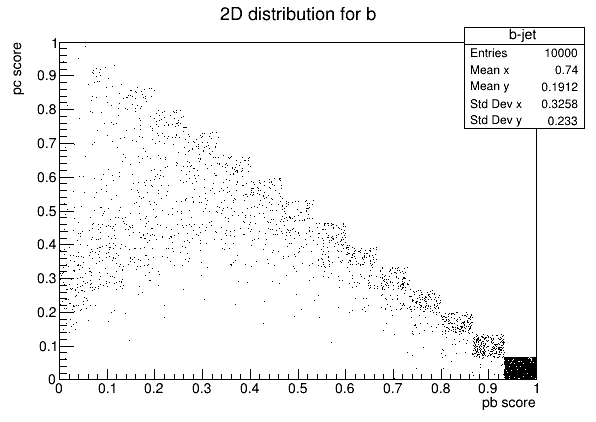

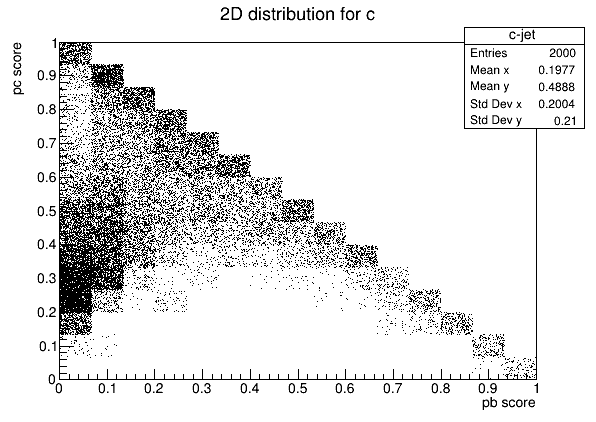

In [88]:
#plot 2d distribution for each jet with 1e4 scales of sample
num = int(1e4)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((1e4)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: b-jet 50000
Warning in <TROOT::Append>: Replacing existing TH1: b-jet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c-jet (Potential memory leak).


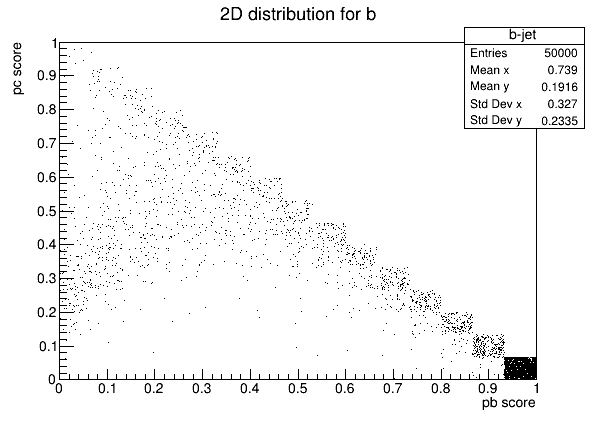

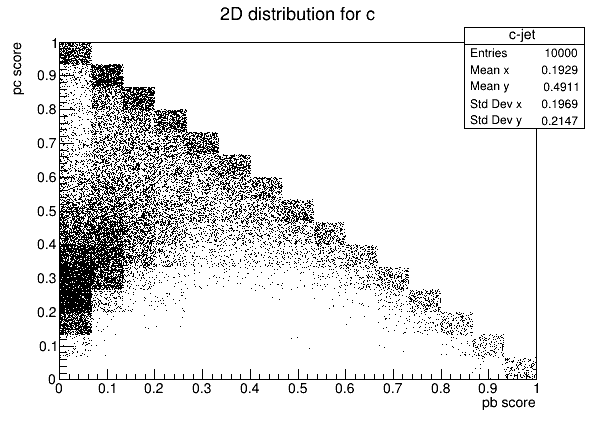

In [90]:
#plot 2d distribution for each jet with 5e4 scales of sample
num = int(5e4)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((5e4)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: b-jet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c-jet (Potential memory leak).


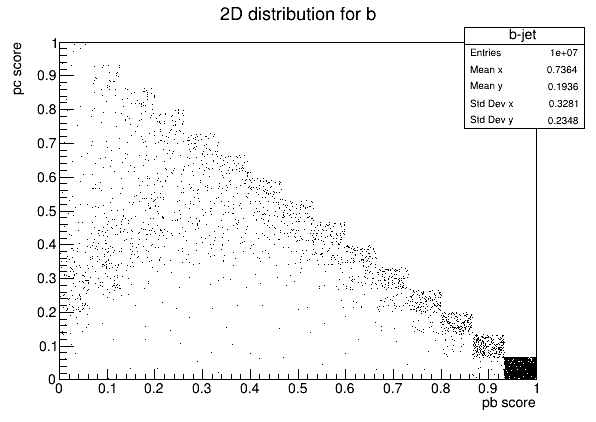

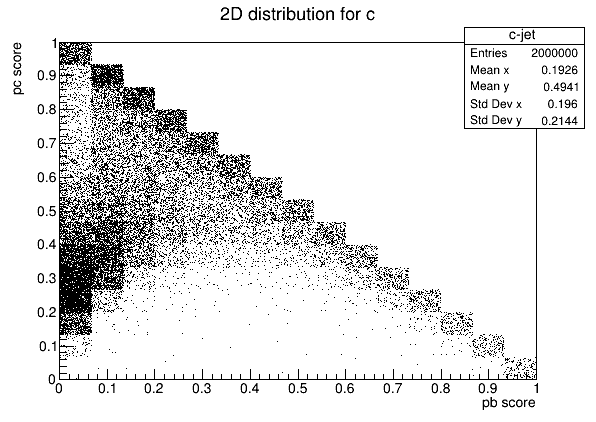

In [93]:
#plot 2d distribution for each jet with 1e5 scales of sample
num = int(1e7)
b = ROOT.TCanvas("b-jet {}".format(num),"The Canvas Title",600,450)
b_2D = ROOT.TH2F("b-jet", "2D distribution for b", 15, 0, 1, 15, 0, 1)
b_2D.FillN(num, b_jet[:, 0], b_jet[:, 1], 1/num*np.ones(num))
b_2D.Draw()
b.cd()
b_2D.GetYaxis().SetTitle("pc score")
b_2D.GetXaxis().SetTitle("pb score")
b.Draw()


num = int((1e7)/5)
c = ROOT.TCanvas("c-jet {}".format(num),"The Canvas Title",600,450)
c_2D = ROOT.TH2F("c-jet", "2D distribution for c", 15, 0, 1, 15, 0, 1)
c_2D.FillN(num, c_jet[:, 0], c_jet[:, 1], 1/num*np.ones(num))
c_2D.Draw()
c.cd()
c_2D.GetYaxis().SetTitle("pc score")
c_2D.GetXaxis().SetTitle("pb score")
c.Draw()


In [5]:
#train test split
X_t, X_test, y_t, y_test = train_test_split(data_X, data_y, train_size=500000, random_state=114514)

In [11]:
#train validation split
X_train_full, X_vali, y_train_full, y_vali = train_test_split(X_t, y_t, test_size=50000, random_state=114514)
print(y_vali.shape)

(50000,)
True


In [7]:
#recompute baseline performance
y_baseline = y_vali.reshape((y_vali.shape[0], 1))
b_jet = X_vali[y_baseline[:, 0] == 0]
c_jet = X_vali[y_baseline[:, 0] == 1]

#Calculate ATLAS_score(ln(pc/pb))
b_ATLAS = np.log(np.divide(b_jet[:,1], b_jet[:,0]))
c_ATLAS = np.log(np.divide(c_jet[:,1], c_jet[:,0]))

#Calculate CMS_score(pc/(pc+pb))
b_CMS = np.divide(b_jet[:,1], b_jet[:, 0] + b_jet[:, 1])
c_CMS = np.divide(c_jet[:,1], c_jet[:, 0] + c_jet[:, 1])

b_len, c_len = b_jet.shape[0], c_jet.shape[0] #The total number of each jet

#calculate efficiency for two discriminant method
#ATLAS-score
thresh_ATLAS = np.linspace(-5.45, 3.85, 50)
b_eff_ATLAS = np.array([np.count_nonzero((b_ATLAS > thresh)) for thresh in thresh_ATLAS])/b_len
c_eff_ATLAS = np.array([np.count_nonzero((c_ATLAS > thresh)) for thresh in thresh_ATLAS])/c_len
b_rej_ATLAS = 1/b_eff_ATLAS
#CMS-score
thresh_CMS = np.linspace(0.01, 0.979, 50)
b_eff_CMS = np.array([np.count_nonzero((b_CMS > thresh)) for thresh in thresh_CMS])/b_len
c_eff_CMS = np.array([np.count_nonzero((c_CMS > thresh)) for thresh in thresh_CMS])/c_len
b_rej_CMS = 1/b_eff_CMS

In [8]:
print(c_jet.shape[0]/(b_jet.shape[0]), b_jet.shape[0]/(b_jet.shape[0]+c_jet.shape[0]))


0.21483065260702658 0.82316


In [24]:
def balanced_accuracy(y_true, y_pred):
    bool_table = (y_true == y_pred)
    true_positive = bool_table[y_true[:,0] == 1]
    true_negative = bool_table[y_true[:,0] == 0]
    tnr = np.count_nonzero(true_negative)/true_negative.shape[0]
    if true_positive.shape[0] == 0:
        print(tnr)
        return tnr
    else:
        tpr = np.count_nonzero(true_positive)/true_positive.shape[0]
        print(tpr, tnr)
        return (tpr+tnr)/2

### Training with 10k samples

epoch = 5, batch size = 256, learning rate = 3e-3,
optimizer: Adam, criterion: BCELoss; model name: model_10k; 
exponentially decaying learning rate with gamma = 0.9

In [33]:
#prepare training dataset
X_train, y_train = X_train_full[:10000, :], y_train_full[:10000]

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
dataset_vali = torch.utils.data.TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 10
batch_size = 256
learning_rate = 3e-4
num_features = 2 #for this prototyping NN, only use pb and pc as the input features
model_10k = custom1(num_features).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model_10k.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle = True) 

train_accu_lst, vali_accu_lst = [], []
train_loss_lst, vali_loss_lst = [], []
model_10k.train()
for epoch in range(epochs):
    model_10k.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = model_10k(X)
        #reconstruct criterion based on each data label
        #weight = torch.clone(y)
        #weight[weight[:, 0] == 0] = 0.21
        #criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()
    mean_loss = np.mean(train_losses)
    train_loss_lst.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)
    
    #training accuracy
    with torch.no_grad():
        model_10k.eval() #evaluation mode
        accu_list = []
        for train_data in dataloader_train:
            X, y = train_data[0], train_data[1]
            y = y.type(torch.FloatTensor)
            X, y = X.float().to(device), y.to(device)
            y = y.view(y.size(0), -1)
            prediction = model_10k(X)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
        model_10k.train()
        train_accu = np.mean(accu_list)
        print("train accu:", train_accu)
        train_accu_lst.append(train_accu)

    #validation accuracy
    with torch.no_grad():
        model_10k.eval()
        #Calculate the validation accuray
        accu_list = []
        validation_losses = []
        for vali_data in dataloader_vali:
            X, y = vali_data[0], vali_data[1]
            y = y.type(torch.FloatTensor)
            X, y = X.float().to(device), y.to(device)
            y = y.view(y.size(0), -1)
            
            prediction = model_10k(X)
            loss = criterion(prediction, y)

            prediction = np.round(prediction.numpy() + 0.1)
            #accu = np.count_nonzero(prediction == y.numpy())
            accu = sklearn.metrics.balanced_accuracy_score(y.numpy(), prediction)
            accu_list.append(accu)
            validation_losses.append(loss.item())
        model_10k.train()
        mean_loss = np.mean(validation_losses)
        vali_loss_lst.append(mean_loss)

        vali_accu = np.mean(accu_list)
        print(f"vali accu: {vali_accu}, vali loss: {mean_loss}")
        vali_accu_lst.append(vali_accu)

device: cpu


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.6408983021974564
train accu: 0.5
vali accu: 0.5, vali loss: 0.534336831192581


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.4383507058024406
train accu: 0.5
vali accu: 0.5, vali loss: 0.3918671704524634


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.3604768879711628
train accu: 0.544073988525869
vali accu: 0.5449718924782111, vali loss: 0.3308134048568959


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.3053713947534561
train accu: 0.7793742749770886
vali accu: 0.7736961219138953, vali loss: 0.3033766993606577


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.29309191443026067
train accu: 0.7927042153801749
vali accu: 0.7878548155142822, vali loss: 0.2996723536325961


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.2888250112533569
train accu: 0.7843262726084743
vali accu: 0.7805065501206001, vali loss: 0.2987255145396505


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.29436898306012155
train accu: 0.7886308202609909
vali accu: 0.7862116496602334, vali loss: 0.29813146940907653


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.2897722199559212
train accu: 0.7994051749286342
vali accu: 0.7875576455188787, vali loss: 0.2988672550691634


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.29665445610880853
train accu: 0.7984111039058306
vali accu: 0.78490185517854, vali loss: 0.2978854665950853


  0%|          | 0/40 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.28535640649497507
train accu: 0.7931901763222353
vali accu: 0.7854613205924214, vali loss: 0.2975380528642207


In [35]:
#training without reweighting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#set training hyperparameter for training:
epochs = 5
batch_size = 256
learning_rate = 3e-3

num_features = 2 #for this prototyping NN, only use pb and pc as the input features
modelw = custom1(num_features).to(device)
optimizerw = torch.optim.Adam(modelw.parameters(), lr = learning_rate)
#criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.21, 1], device=device), reduction='none')
criterion = nn.BCELoss()
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle =True)
dataloader_vali = torch.utils.data.DataLoader(dataset_vali, batch_size = batch_size, shuffle =True)

train_accu_lst, vali_accu_lst = [], []
train_loss_lst, vali_loss_lst = [], []
modelw.train()
for epoch in range(epochs):
    modelw.train()
    train_losses = []
    for X, y in tqdm.notebook.tqdm(dataloader_train, unit= "batch"):
        optimizerw.zero_grad()
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = modelw(X)
        #reconstruct criterion based on each data label
        weight = torch.clone(y)
        weight[weight[:, 0] == 0] = 0.21
        #criterion = nn.BCELoss(weight = weight)
        loss = criterion(prediction, y)

        loss.backward()
        optimizerw.step()
        train_losses.append(loss.item())
    mean_loss = np.mean(train_losses)
    train_loss_lst.append(mean_loss)
    print("Finished Epoch", epoch+1, ", training loss:", mean_loss)

device: cuda


  0%|          | 0/15287 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.2919790619641763


  0%|          | 0/15287 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.2908310797137385


  0%|          | 0/15287 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.2906988406410209


### Draw roc curve to see the performance

In [38]:
pred_lst = []
with torch.no_grad():
    model_10k.eval()
    for vali_data in dataloader_vali:
        X, y = vali_data[0], vali_data[1]
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = model_10k(X)
        prediction = prediction.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        result = np.hstack((prediction,y))
        pred_lst.append(result)
    model_10k.train()

pred_label = np.concatenate(pred_lst)
print(pred_label.shape)
    
        

(50000, 2)


In [32]:
#prediction with model without training
predw_lst = []
with torch.no_grad():
    modelw.eval()
    for vali_data in dataloader_vali:
        X, y = vali_data[0], vali_data[1]
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = modelw(X)
        prediction = prediction.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        result = np.hstack((prediction,y))
        predw_lst.append(result)
    modelw.train()

predw_label = np.concatenate(predw_lst)
print(predw_label.shape)
    

(434826, 2)


In [28]:
predw_lst, pred_lst = [],[]
with torch.no_grad():
    modelw.eval()
    model.eval()
    for vali_data in dataloader_vali:
        X, y = vali_data[0], vali_data[1]
        y = y.type(torch.FloatTensor)
        X, y = X.float().to(device), y.to(device)
        y = y.view(y.size(0), -1)
        prediction = modelw(X)
        prediction = prediction.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        pred = model(X)
        pred = pred.cpu().detach().numpy()
        result_w = np.hstack((prediction, y))
        result = np.hstack((pred, y))
        predw_lst.append(result_w)
        pred_lst.append(result)
        break

predw_label = np.array(predw_lst).squeeze()
pred_label = np.array(pred_lst).squeeze()
print(predw_label.shape)

(256, 2)


In [37]:
b_CUSTOM1w = predw_label[predw_label[:, 1] == 0]
c_CUSTOM1w = predw_label[predw_label[:, 1] == 1]
b_len, c_len = b_CUSTOM1w.shape[0], c_CUSTOM1w.shape[0]
print(np.max(b_CUSTOM1w[:,0]), np.min(b_CUSTOM1w[:,0]), np.max(c_CUSTOM1w[:,0]), np.min(c_CUSTOM1w[:,0]))

thresh_CUSTOM1w = np.linspace(0.00046, 0.881, 100)
b_eff_CUSTOM1w = np.array([np.count_nonzero((b_CUSTOM1w[:, 0] > thresh)) for thresh in thresh_CUSTOM1w])/b_len
c_eff_CUSTOM1w = np.array([np.count_nonzero((c_CUSTOM1w[:, 0] > thresh)) for thresh in thresh_CUSTOM1w])/c_len
b_rej_CUSTOM1w = 1/b_eff_CUSTOM1w

0.8814636 0.00046681621 0.8846539 0.00048034097


0.64751345 0.008371004 0.6502265 0.008566681


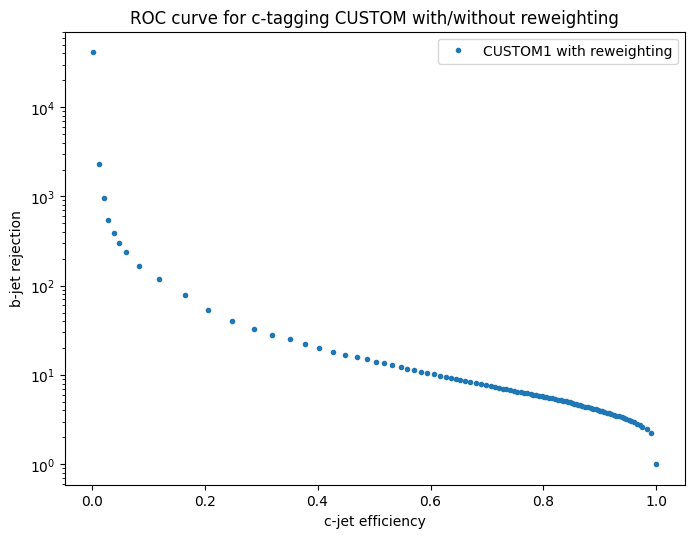

In [41]:
b_CUSTOM1 = pred_label[pred_label[:, 1] == 0]
c_CUSTOM1 = pred_label[pred_label[:, 1] == 1]
b_len, c_len = b_CUSTOM1.shape[0], c_CUSTOM1.shape[0]
print(np.max(b_CUSTOM1[:,0]), np.min(b_CUSTOM1[:,0]), np.max(c_CUSTOM1[:,0]), np.min(c_CUSTOM1[:,0]))

thresh_CUSTOM1 = np.linspace(0.0083, 0.6475, 100)
b_eff_CUSTOM1 = np.array([np.count_nonzero((b_CUSTOM1[:, 0] > thresh)) for thresh in thresh_CUSTOM1])/b_len
c_eff_CUSTOM1 = np.array([np.count_nonzero((c_CUSTOM1[:, 0] > thresh)) for thresh in thresh_CUSTOM1])/c_len
b_rej_CUSTOM1 = 1/b_eff_CUSTOM1


plt.figure(figsize=(8,6), dpi=100)
plt.plot(c_eff_CUSTOM1, b_rej_CUSTOM1, ".", label = "CUSTOM1 with reweighting")
#plt.plot(c_eff_CUSTOM1w, b_rej_CUSTOM1w, label = "CUSTOM1 without reweighting")
#plt.plot(c_eff_ATLAS, b_rej_ATLAS, label = "ATLAS-like")
#plt.plot(c_eff_CMS, b_rej_CMS, label = "CMS-like")
plt.yscale("log", base = 10)
plt.xlabel("c-jet efficiency")
plt.ylabel("b-jet rejection")
plt.title("ROC curve for c-tagging CUSTOM with/without reweighting")
plt.legend()
plt.show()